In [ ]:
# Copyright 2023, Acadential, All rights reserved.

# 14.7 PyTorch로 구현해보는 CNN layer 및 모델

저희가 이번 Section에서 배운 내용을 기반으로 CNN 모델을 직접 만들어보도록 하겠습니다.


# Import libraries

In [1]:
import torch
from torch import nn

# CPU, GPU Device 확인하기

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


# ```nn.Module```에 대한 Recap

섹션 2에서 저희는 ```nn.Module```을 사용해서 FC Layer 기반의 Neural Network을 만들어보았습니다.

```nn.Module```을 사용하려면 기본적으로 다음 두 ```Method```을 Override 합니다:
1. ```__init__``` : 신경망 모듈에서 사용되는 모든 모듈을 정의합니다.
2. ```forward``` : 신경망 모듈에서 사용되는 모든 모듈의 연산을 정의합니다.

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Neural Network을 구성하는 layer들을
        # initialize하는 부분
        pass

    def forward(self, x):
        # Neural Network의 forward pass을 정의하는 부분
        # x은 input tensor
        pass

# Define CNN Model

CNN의 기본 Building Block의 구조는 Conv2D, Batch Norm, ReLU, Pooling으로 구성되어 있다고 설명드렸습니다.

저희도 이렇게 CNN 모델을 구성해보도록 하겠습니다.

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(2), # 32 // 2 -> 16
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2),  # 16 // 2 -> 8
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2),  # 8 // 2 -> 4
            nn.Flatten(),
            nn.Linear(64*4*4, 10),
        )
        
        for layer in self.conv:
            self._init_weights(layer)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Conv2d):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        logits = self.conv(x)
        return logits

In [4]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=1024, out_features=10, bias=True)
  )
)


## Model class의 구성 요소

1. ```__init__``` 함수
2. ```forward``` 함수

### ```__init__``` (Initialization 함수)
- Initialization 함수에서는 NN model을 구성하는 layer들을 명시합니다.. \
- 즉, 위 예제에서는 " ( Conv2d -> ReLU -> BatchNorm2d -> AvgPool2d ) x 3 -> Flatten -> Linear " 로 구성된 layer들을 명시하였다.

즉, 각 Conv Block은 (Conv2d -> ReLU -> BatchNorm2d -> AvgPool2d)로 구성되어 있습니다.

### ```forward``` 함수
- 입력 (input) 에 대한 forward pass을 정의합니다.

forward pass 상에서는 각 layer에서 인풋과 출력값의 shape은 다음과 같이 바뀝니다.:

- 0\~3: shape == (1, 3, 32, 32) -> after Conv2d -> (1, 16, 32, 32) -> after AvgPool2d ->(1, 16, 16, 16)
- 4\~7: shape == (1, 16, 16, 16) -> after Conv2d -> (1, 32, 16, 16) -> after AvgPool2d -> (1, 32, 8, 8)
- 8\~11: shape == (1, 32, 8, 8) -> after Conv2d -> (1, 64, 8, 8) -> after AvgPool2d -> (1, 64, 4, 4)
- 12: shape == (1, 64, 4, 4) -> (1, 64 * 4 * 4)
- 13: shape == (1, 64 * 4 * 4) -> (1, 10)

# Weight Initialization

저희가 Section 12의 Initialization 에서 살펴보았듯이:
1. Xavier initialization: sigmoid, tanh 활성화 함수에 적합합니다.
2. He initialization (kaiming): ReLU 활성화 함수에 적합합니다.

저희는 위 예제에서 ReLU activation 함수를 사용하니 Kaiming He Initialization을 사용하겠습니다.

## He Initialization
```torch.nn.init.kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')```
[참고 링크](https://pytorch.org/docs/stable/nn.init.html)

Initialization에 대한 코드를 살펴보면:

```
def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Conv2d):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
                
```

여기서 ```nn.Linear layer```에 대해서는 weight을 Gaussian normal distribution으로 initialization합니다. \
그리고 ```nn.Conv2d``` layer에 대해서는 kaiming_uniform으로 initialization하는 것입니다. \
Bias term은 0으로 initialize합니다.

# Forward pass

In [5]:
X = torch.rand(1, 3, 32, 32, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([4])


# NN Layers

위 예시에서 살펴본 Neural Network을 구성하는 각 layer을 살펴보면 다음과 같습니다:
1. nn.Conv2d
2. nn.BatchNorm2d
3. nn.ReLU
4. nn.AvgPool2d
5. nn.Flatten
6. nn.Linear
7. nn.Softmax


<!-- 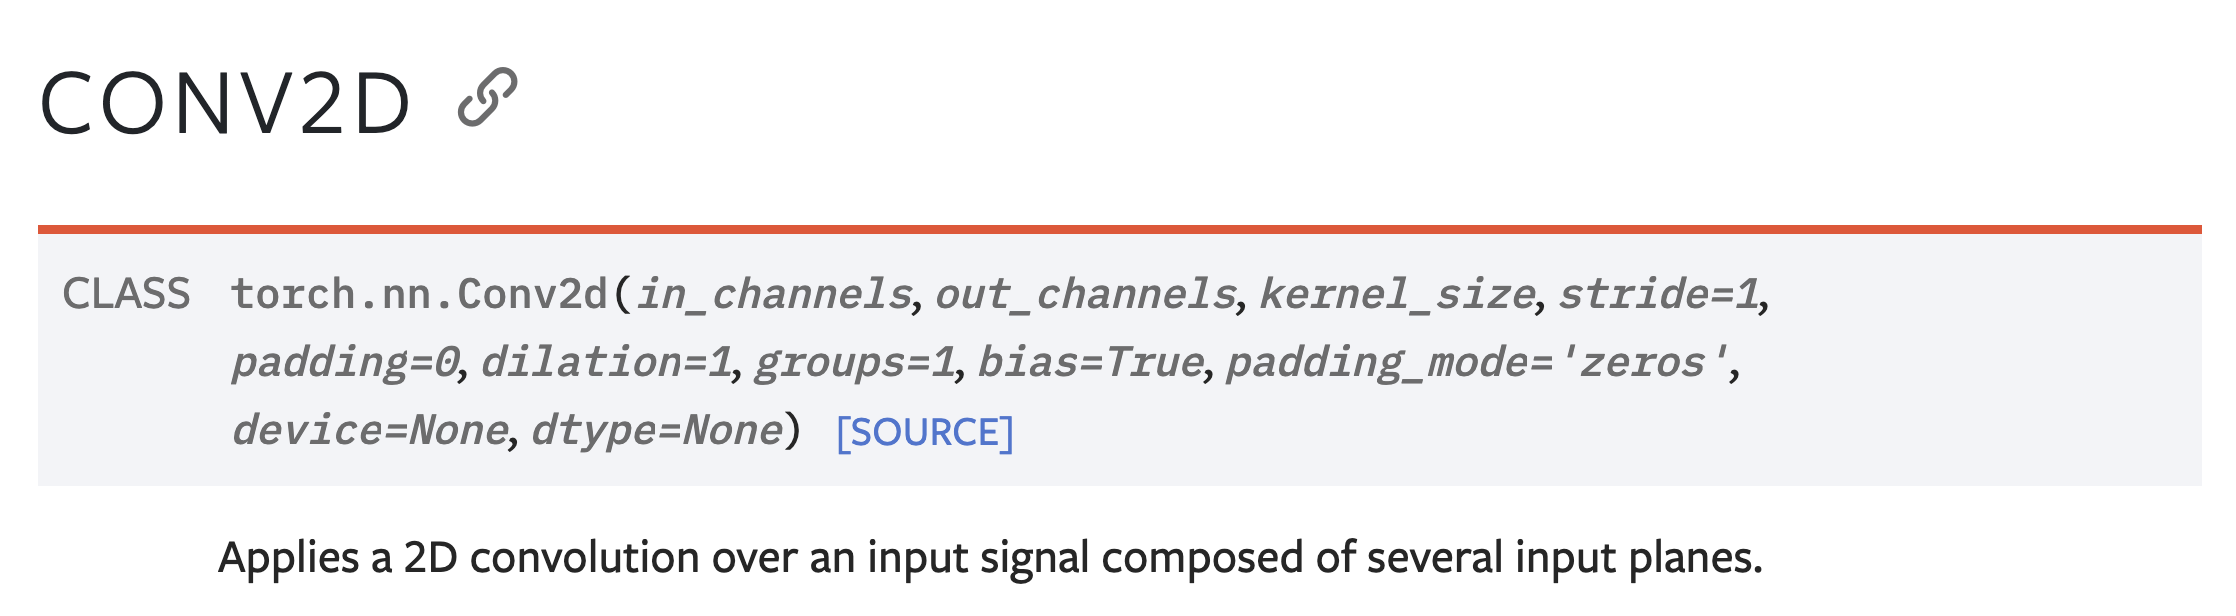 -->

<div>
<center>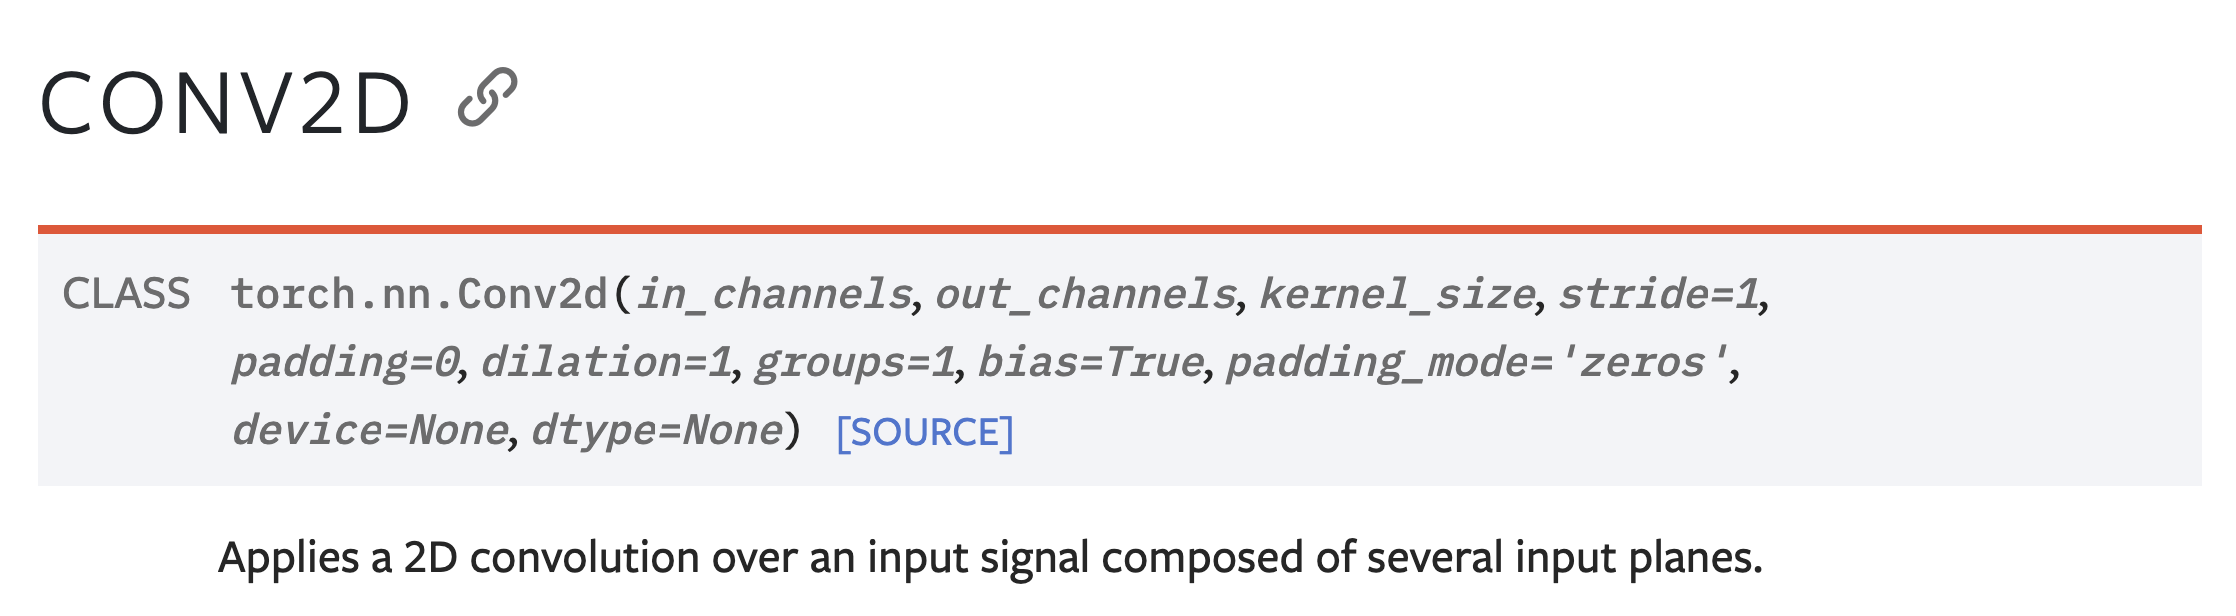</center>
<div>
    


In [8]:
X = torch.rand(1, 3, 32, 32, device=device)
conv_layer = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
conv_out = conv_layer(X)

In [9]:
print("input shape = ", X.shape)
print("output shape = ", conv_out.shape)

input shape =  torch.Size([1, 3, 32, 32])
output shape =  torch.Size([1, 16, 32, 32])


### ```AvgPool2d```

Pooling Layer:
- 점차 abstract, global한 feature을 뽑아내도록 Conv2d layer에서 출력된 feature map의 크기를 줄여나갑니다.
- 아래 예시에서는 kernel size=2 (stride=kernel size by default)의 pooling layer 사용하고 있습니다.
- 저희가 만든 모델에서도 ```AvgPool2d```을 사용하여 Feature map의 크기를 줄여나갑니다.

In [18]:
pool_in = torch.rand(1, 16, 32, 32, device=device)
pool_layer = nn.AvgPool2d(2) # 32 // 2 -> 16
pool_out = pool_layer(pool_in)

In [19]:
print("input shape = ", pool_in.shape)
print("output shape = ", pool_out.shape)

input shape =  torch.Size([1, 16, 32, 32])
output shape =  torch.Size([1, 16, 16, 16])


### ```nn.Flatten```

- Multi-dimensional한 tensor을 single dimensional한 vector로 "flatten"해줍니다.
- 참고로, first-dimension은 batch에 해당되므로 그대로 둬야합니다.
- 이러한 이유로 Flatten은 기본적으로 (by default)로 first-dimension에 대해서는 flatten하지 않습니다.

In [20]:
flat_in = torch.rand(1, 64, 4, 4)
flatten = nn.Flatten()
flat_out = flatten(flat_in)

In [21]:
print("input shape = ", flat_in.shape)
print("output shape = ", flat_out.shape)

input shape =  torch.Size([1, 64, 4, 4])
output shape =  torch.Size([1, 1024])


## Model Summary

In [35]:
from torchsummary import summary


In [38]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
         AvgPool2d-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 32, 16, 16]           4,640
       BatchNorm2d-6           [-1, 32, 16, 16]              64
              ReLU-7           [-1, 32, 16, 16]               0
         AvgPool2d-8             [-1, 32, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          18,496
      BatchNorm2d-10             [-1, 64, 8, 8]             128
             ReLU-11             [-1, 64, 8, 8]               0
        AvgPool2d-12             [-1, 64, 4, 4]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                   